In [1]:
import os
wd = os.getcwd()
wd = os.path.dirname(os.path.dirname(wd))

In [2]:
import sys
sys.path.append(wd+"\\src\\")
from tube import Tube, InterpXY
from gaslayer import GasEOS, GasFluxCalculator, GridStrecher, GasLayer
from pistonlayer import ElPistLayer, ElPistEOS
from powderlayer import Powder, PowderOvLayer, PowderBD
from math import *
import numpy as np

In [3]:
from tqdm import tqdm_notebook
from matplotlib.patches import Polygon
import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed
import ipywidgets

%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 

mpl.rcParams['figure.figsize'] = (5,3) 

In [4]:
import json
from functional import seq
import ipdb

### Debugging
https://appletree.or.kr/quick_reference_cards/Python/Python%20Debugger%20Cheatsheet.pdf

### Труба

In [5]:
tube_dict_sample = {
    'tube_points': [[0, 0.023], [1, 0.023], [1.3, 0.023*0.5], [1.5, 0.023*0.5]]
}



Tube.get_standart(tube_dict_sample)

Tube(xs=[0.0, 1.0, 1.3, 1.5], ds=[0.023, 0.023, 0.0115, 0.0115])

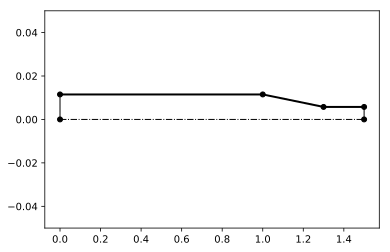

In [6]:
ax, fig = plt.subplots()
tube = Tube.get_standart(tube_dict_sample)
tube.plot(ax, fig)
fig.set_ylim(-0.05,0.05)
plt.show()

### Граница

In [7]:
border_dict_sample = {
    'mass': 0.1, # kg
    'p_f': 100e6, #Pa
    't_init': -1,
    'w_border': 0.005, #m
}

class BorderSimple(object):
#     @staticmethod
#     def connect(b_left: BorderSimple, b_right: BorderSimple, f_destroy=0, l_0=None):
#         if l_0 is None:
#             l_0 = b_right.get_x_left() - b_left.get_x_right() 
        
    @classmethod
    def get_standart(cls, border_dict):
        return cls(None, None, **border_dict)
        
    def __init__(self, 
                 lr_left: GasLayer, 
                 lr_right: GasLayer, 
                 mass: float, 
                 p_f:float, 
                 t_init=-1, 
                 w_border=0, **kwargs):
        
        self.lr_left= lr_left
        self.lr_right = lr_right
        self.mass = mass
        self.p_f = p_f
        self.t_init = t_init
        self.w_border = w_border
        self.color_4_plot = 'black'
        
    def __str__(self):
        return f'BorderSimple(mass={self.mass}, p_f={self.p_f}, t_init={self.t_init}, w_border={self.w_border})'
    
    def get_p_s_left(self):
        if self.lr_left is not None:
            return self.lr_left.get_p_right(), self.lr_left.S[-1]
        return 0, 0
        
    def get_p_s_right(self):
        if self.lr_right is not None:
            return self.lr_right.get_p_left(), self.lr_right.S[0]
        return 0, 0
    
    def get_right_layer_x1(self):
        return self.lr_left.xs_borders[-1] + self.w_border
    
    def get_x_left(self):
        if self.lr_left is not None:
            return self.lr_left.xs_borders[-1]
        if self.lr_right is not None:
            return self.get_x_right() - self.w_border
        return 0
    
    def get_x_right(self):
        if self.lr_right is not None:
            return self.lr_right.xs_borders[0]
        if self.lr_left is not None:
            return self.get_x_left() + self.w_border
        return 0
    
    def get_v0(self):
        v0 = None
        if self.lr_left is not None:
            v0 = self.lr_left.Vs_borders[-1]
        if self.lr_right is not None:
            if v0 is not None:
                if abs(self.lr_right.xs_borders[0] - self.get_right_layer_x1()) > 1e-5:
                    raise AttributeError(f'Слои не синхронизированы по координатам!\n{self.lr_left}\n{self.lr_right}')
                vr = self.lr_right.Vs_borders[0]
                if abs(vr-v0) > 1e-10:
                    raise AttributeError(f'Слои не синхронизированы по скорости!\n{self.lr_left}\n{self.lr_right}')
            v0 = self.lr_right.Vs_borders[0]
        return v0
    
    def get_v0_f0_a0(self):
        v0 = self.get_v0()
        (pl, sl), (pr, sr) = self.get_p_s_left(), self.get_p_s_right()
        f0 = pl*sl - pr*sr
        if abs(v0) < 1e-13 and abs(pl - pr) < self.p_f:
            a0 = 0
        else:
            a0 = f0/self.mass
        return v0, f0, a0
    
    def update_Vs(self, tau: float):
        v0, f0, a0 = self.get_v0_f0_a0()
        v1 = v0 + tau*a0
        if self.lr_left is not None:
            self.lr_left.Vs_borders[-1] = v1
        if self.lr_right is not None:
            self.lr_right.Vs_borders[0] = v1
            
    def update_xs(self):
        if self.lr_left is not None and self.lr_right is not None:
            self.lr_right.xl = self.lr_left.xs_borders[-1] + self.w_border
            self.lr_left.xr = self.lr_left.xs_borders[-1]
        elif self.lr_left is None:
            self.lr_right.xl = self.lr_right.xs_borders[0]
        elif self.lr_right is None:
            self.lr_left.xr = self.lr_left.xs_borders[-1]
            
    def plot(self, fig, ax, **kwargs):
        """
        fig, ax = plt.subplots()

        n_points = kwargs.get('n_points', 10)
        y0 = kwargs.get('y0', 0)
        color=kwargs.get('color', self.color_4_plot)
        lw = kwargs.get('lw', 2)
        kwargs.get('plot_tube', False)
        """
        n_points = kwargs.get('n_points', 10)
        y0 = kwargs.get('y0', 0)
        color=kwargs.get('color', self.color_4_plot)
        lw = kwargs.get('lw', 2)
        if self.lr_left is not None:
            tube = self.lr_left.tube
        elif self.lr_right is not None:
            tube = self.lr_right.tube
        else:
            raise AttributeError(f'Нет слоев( ')
        if kwargs.get('plot_tube', False):
            tube.plot(fig, ax, **kwargs)
        if abs(self.w_border) < 1e-9:
            x = self.get_x_left()
            ax.plot([x, x], [y0, tube.get_d(x)/2+y0], color=color, lw=lw)
            return
        ix = np.linspace(self.get_x_left(), self.get_x_right(), n_points)
        iy = np.array(tube.get_ds(ix))/2 + y0
        verts = [(ix[0], y0)] + list(zip(ix, iy)) + [(ix[-1], y0)]
        poly = Polygon(verts, facecolor='1', edgecolor='0.1', hatch=r'//')
        ax.add_patch(poly)
        
    def copy(self):
        return BorderSimple(lr_left=self.lr_left, 
                 lr_right=self.lr_right, 
                 mass=self.mass, 
                 p_f=self.p_f, 
                 t_init=self.t_init, 
                 w_border=self.w_border)
    

### Пороховой слой

In [8]:
PowderBD().all_powders_dict['4\\7']

{'name': '4\\7',
 'f': 1.027,
 'etta': 0.228,
 'alpha_k': 1.008,
 'T_1': 3006.0,
 'ro': 1.6,
 'I_k': 0.32,
 'Z_k': 1.488,
 'k_1': 0.811,
 'lambda_1': 0.081,
 'k_2': 0.505,
 'lambda_2': -1.024,
 'k_f': 0.0003,
 'k_l': 0.0016}

In [9]:
powder_layer_dict_sample = {
    'type': 'powder',
    'powder': {
        'name': '4\\7',
        'f': 1.027,
        'etta': 0.228,
        'alpha_k': 0,# 1.008,
        'T_1': 3006.0,
        'ro': 1.6,
        'I_k': 0.32,
        'Z_k': 1.488,
        'k_1': 0.811,
        'lambda_1': 0.081,
        'k_2': 0.505,
        'lambda_2': -1.024,
        'k_f': 0.0003,
        'k_l': 0.0016
    },
    'omega': 35,  # грамм
    'delta': 700, # г/cm^3
    'p_0': 5e6, # начальное давление
    't_ign': 0,#0.000001, # начало горения
    'u_0': 0,     #начальная скорость
}

calc_settings_sample = {
    'cell_dx': 0.0025,
    'n_cells_min': 13,
    'n_cells_max': 300,
    'GasFluxCalculator_kwargs': {'flux_type':2},
    'GridStrecher_kwargs': {}
}   

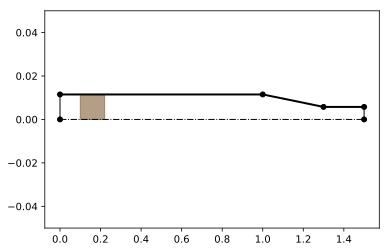

{'time': 0.0,
 'n_qs': 4,
 'xs_cells': array([0.10125358, 0.10376075, 0.10626792, 0.10877508, 0.11128225,
        0.11378942, 0.11629658, 0.11880375, 0.12131092, 0.12381808,
        0.12632525, 0.12883242, 0.13133958, 0.13384675, 0.13635392,
        0.13886108, 0.14136825, 0.14387542, 0.14638258, 0.14888975,
        0.15139692, 0.15390408, 0.15641125, 0.15891842, 0.16142558,
        0.16393275, 0.16643992, 0.16894708, 0.17145425, 0.17396142,
        0.17646858, 0.17897575, 0.18148292, 0.18399008, 0.18649725,
        0.18900442, 0.19151159, 0.19401875, 0.19652592, 0.19903309,
        0.20154025, 0.20404742, 0.20655459, 0.20906175, 0.21156892,
        0.21407609, 0.21658325, 0.21909042]),
 'xs_borders': array([0.1       , 0.10250717, 0.10501433, 0.1075215 , 0.11002867,
        0.11253583, 0.115043  , 0.11755017, 0.12005733, 0.1225645 ,
        0.12507167, 0.12757883, 0.130086  , 0.13259317, 0.13510033,
        0.1376075 , 0.14011467, 0.14262183, 0.145129  , 0.14763617,
        0.15014333

In [10]:
tube=Tube.get_standart(tube_dict_sample)
pl = PowderOvLayer.get_standart(tube, 0.1, powder_layer_dict_sample, calc_settings_sample)

fig, ax = plt.subplots()
tube.plot(fig, ax)
pl.plot(fig, ax)
ax.set_ylim(-0.05,0.05)
plt.show()

pl
pl.to_dict()

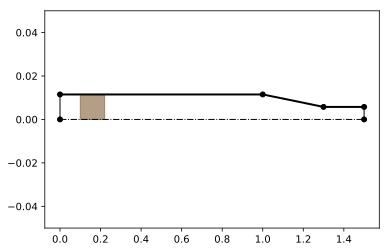

{'time': 2.0077485058822995e-06,
 'n_qs': 4,
 'xs_cells': array([0.10125358, 0.10376075, 0.10626792, 0.10877508, 0.11128225,
        0.11378942, 0.11629658, 0.11880375, 0.12131092, 0.12381808,
        0.12632525, 0.12883242, 0.13133958, 0.13384675, 0.13635392,
        0.13886108, 0.14136825, 0.14387542, 0.14638258, 0.14888975,
        0.15139692, 0.15390408, 0.15641125, 0.15891842, 0.16142558,
        0.16393275, 0.16643992, 0.16894708, 0.17145425, 0.17396142,
        0.17646858, 0.17897575, 0.18148292, 0.18399008, 0.18649725,
        0.18900442, 0.19151159, 0.19401875, 0.19652592, 0.19903309,
        0.20154025, 0.20404742, 0.20655459, 0.20906175, 0.21156892,
        0.21407609, 0.21658325, 0.21909042]),
 'xs_borders': array([0.1       , 0.10250717, 0.10501433, 0.1075215 , 0.11002867,
        0.11253583, 0.115043  , 0.11755017, 0.12005733, 0.1225645 ,
        0.12507167, 0.12757883, 0.130086  , 0.13259317, 0.13510033,
        0.1376075 , 0.14011467, 0.14262183, 0.145129  , 0.14763617,

In [11]:
tau = pl.get_tau_min()*0.1
pl = pl.step_simple(tau, 0,0)

pl.step_simple(tau, 0,0)

fig, ax = plt.subplots()
tube.plot(fig, ax)
pl.plot(fig, ax)
ax.set_ylim(-0.05,0.05)
plt.show()

pl.to_dict()

### Газовый слой

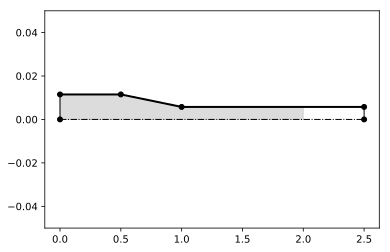

GasLayer(n_cells=600); 
        {'p_max':40000000.0, 'tau_min': 9.600926649350913e-06, 
        'u_max': 0.0, 'cs_max': 347.18870949384285, 'dx_min': 0.0033333333333331883, 
        'x_1': 0.0, 'x_2': 2.0,
        'V_1':  0.0, 'V_2':  0.0  }

In [57]:
gas_layer_dict_sample = {
    'type': 'gas',
    'name': 'air',
    'gamma': 1.4,
    'kappa': 0, #0.0010838,
    'R': 287,
    'T_0': 300, # K
    'W_0': 0.0003,  # м^3 объем газа
    'p_0': 400e5, # начальное давление газа
    'u_0': 0,     #начальная скорость
    'x_2': 2
}

tube_dict = {
    'tube_points': [[0, 0.023], [0.5, 0.023], [1, 0.023*0.5], [2.5, 0.023*0.5]]
}

calc_settings_sample = {
    'cell_dx': 0.0025,
    'n_cells': 600,
    'n_cells_min': 13,
    'n_cells_max': 300,
    'GasFluxCalculator_kwargs': {'flux_type':1, 'x_order':1, 'alpha_1':1, 'alpha_2':0.5},
    'GridStrecher_kwargs': {}
}   
tube=Tube.get_standart(tube_dict)
gl = GasLayer.get_standart(tube, 0, gas_layer_dict_sample, calc_settings_sample)   

fig, ax = plt.subplots()
tube.plot(fig, ax)
gl.plot(fig, ax)
ax.set_ylim(-0.05,0.05)
plt.show()

gl

In [58]:
lrs = [gl]
for i in range(10000):
    tau = gl.get_tau_min()*0.3
    gl05 = gl.step_simple(tau*0.5, 0, 150)
    gl = gl.corrector(gl05, tau, 0, 150)
    lrs.append(gl)
    

In [59]:
@interact(ind=ipywidgets.IntSlider(min=0,max=len(lrs)-1,step=10, value=0))
def plotMe(ind):
    param_name = 'us'
    lr = lrs[ind]
    fig, ax = plt.subplots()
    xs = np.array(lr.xs_cells)
    ys = np.array(getattr(lr, param_name))
    color = lr.color_4_plot
    lw = 2
    ax.plot(xs, ys, color=color, lw=lw)
    plt.grid(True)
    plt.ylabel(param_name)
#     plt.ylim(-1,1)
    plt.title(f't={lr.time*1000} ms; i={ind}')
    plt.show()

interactive(children=(IntSlider(value=0, description='ind', max=10000, step=10), Output()), _dom_classes=('wid…

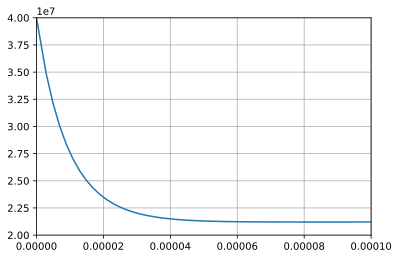

In [61]:
ts = [lr.time for lr in lrs]
pdno = [lr.ps[-1] for lr in lrs]
plt.plot(ts, pdno)
plt.xlim(0,0.0001)
plt.ylim(2e7,4e7)
plt.grid(True)
plt.show()

### Полиэтиленовый слой

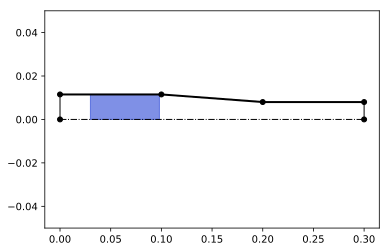

ElPistLayer(n_cells=300); 
        {'p_max':100000.0, 'tau_min': 7.870019456445688e-08, 
        'u_max': 576.0, 'cs_max': 2308.0384458555504, 'dx_min': 0.00022697438682020565, 
        'x_1': 0.03, 'x_2': 0.09809231604606339,
        'V_1':  0.0, 'V_2':  0.0  }

In [145]:
v0 = 576
pist_layer_dict_sample = {
    'type': 'pist',
    'omega': 0.026,  # кг
    'p_0': 1e5, # начальное давление в полиэтилене
    'u_0': v0,     #начальная скорость
    'ElPistEOS_kwargs': dict(
        k=1.63098, 
        c_0=2308, 
        ro_0=919.03, 
        sigma_star=25.2, 
        k_0=0.054, 
        b_1=0.027, 
        b_2=0.00675, 
        tau_0=1.36, 
        mu=0.001, 
        tau_s=1,                 
        zeroP=False, 
        zeroE=True)
}


tube=Tube.get_standart({
'tube_points': [[0, 0.023], [0.1, 0.023], [0.2, 0.016], [0.3, 0.016]]
})
calc_settings_sample2 = {
    'cell_dx': 0.0001,
#     'n_cells': 600,
    'n_cells_min': 13,
    'n_cells_max': 300,
    'GasFluxCalculator_kwargs': {'flux_type':1, 'x_order':1, 'alpha_1':1, 'alpha_2':0.5},
    'GridStrecher_kwargs': {}
}   
pistl = ElPistLayer.get_standart(tube, 0.03, pist_layer_dict_sample, calc_settings_sample2)   

fig, ax = plt.subplots()
tube.plot(fig, ax)
pistl.plot(fig, ax)
ax.set_ylim(-0.05,0.05)
plt.show()

pistl 

In [146]:
lrs = [pistl]
vl = v0
vr = v0
for i in range(40000):
    tau = pistl.get_tau_min()*0.1
    vl -= pistl.get_p_left()*pistl.S[0]/0.042*tau
    vr += pistl.get_p_right()*pistl.S[-1]/0.023*tau
    pistl = pistl.step_simple(tau, vl, vr)
    lrs.append(pistl)
#     if pistl.xs_borders[-1] > 1.5:
#         break
len(lrs)

40001

In [155]:
@interact(ind=ipywidgets.IntSlider(min=0,max=len(lrs)-1,step=100, value=0))
def plotMe(ind):
    param_name = 'us'
    lr = lrs[ind]
    fig, ax = plt.subplots()
    xs = np.array(lr.xs_cells)
    ys = np.array(getattr(lr, param_name))
    color = lr.color_4_plot
    lw = 2
    ax.plot(xs, ys, color=color, lw=lw)
    plt.grid(True)
    plt.ylabel(param_name)
    plt.xlim(0,0.25)
#     plt.ylim(-2000e5,2500e5)
    plt.title(f't={lr.time*1000} ms; i={ind}')
    plt.show()

interactive(children=(IntSlider(value=0, description='ind', max=40000, step=100), Output()), _dom_classes=('wi…

### Бутерброт)

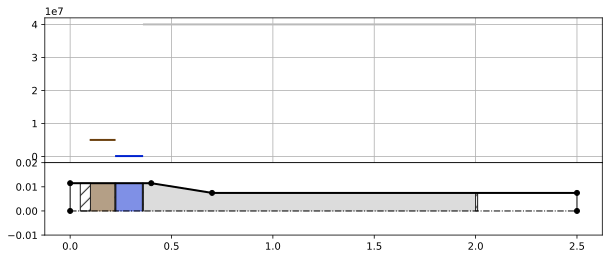

Sandwich i=0; t=0.0 ms;  vel=0.0 m/s;  p_max=40.0 MPa
layers:
0) PowderOvLayer(n_cells=48); 
        {'p_max':5000000.0, 'tau_min': 2.00774850588041e-05, 
        'u_max': 0.0, 'cs_max': 124.87454021397153, 'dx_min': 0.0025071667153710453, 
        'x_1': 0.1, 'x_2': 0.2203440023378107,
        'V_1':  0.0, 'V_2':  0.0  }
        { 'powder': r'4\7', 'z_max': 0.0, 't_ign'=0.0 }
1) ElPistLayer(n_cells=52); 
        {'p_max':100000.0, 'tau_min': 1.091059362067799e-06, 
        'u_max': 0.0, 'cs_max': 2308.0384458555504, 'dx_min': 0.0025182069543631114, 
        'x_1': 0.2253440023378107, 'x_2': 0.3562907639646937,
        'V_1':  0.0, 'V_2':  0.0  }
2) GasLayer(n_cells=300); 
        {'p_max':40000000.0, 'tau_min': 1.5733127174788265e-05, 
        'u_max': 0.0, 'cs_max': 347.18870949384285, 'dx_min': 0.005462364120117247, 
        'x_1': 0.36129076396469373, 'x_2': 2.0,
        'V_1':  0.0, 'V_2':  0.0  }

In [63]:
sandwich_dict_sample = {
    'tube': {
        'tube_points': [[0, 0.023], [0.4, 0.023], [0.7, 0.023*0.65], [2.5, 0.023*0.65]]
    },
    'x_left': 0.1,
    'layers': [
        powder_layer_dict_sample,
        {
            'type': 'pist',
            'omega': 0.05,  # кг
            'p_0': 1e5, # начальное давление в полиэтилене
            'u_0': 0,     #начальная скорость
            'ElPistEOS_kwargs': dict(
                k=1.63098, 
                c_0=2308, 
                ro_0=919.03, 
                sigma_star=25.2, 
                k_0=0.054, 
                b_1=0.027, 
                b_2=0.00675, 
                tau_0=1.36, 
                mu=0.001, 
                tau_s=1,                 
                zeroP=False, 
                zeroE=False)
        },
        gas_layer_dict_sample,
        
    ],
    'borders': [
        {
            'mass': 1000, # kg
            'p_f': 100000e6, #Pa
            't_init': -1,
            'w_border': 0.05, #m
        },
        {
            'mass': 0.01, # kg
            'p_f': 300e6, #Pa
            't_init': -1,
            'w_border': 0.005, #m
        },
        {
            'mass': 0.01, # kg
            'p_f': 300e6, #Pa
            't_init': -1,
            'w_border': 0.005, #m
        },
        {
            'mass': 0.1, # kg
            'p_f': 400e6, #Pa
            't_init': -1,
            'w_border': 0.01, #m
        },
    ],
    'calc_settings': {
        'powder_settings': {
            'cell_dx': 0.0025,
            'n_cells_min': 13,
            'n_cells_max': 300,
            'GasFluxCalculator_kwargs': {'flux_type':2},
            'GridStrecher_kwargs': {}
        },
        'gas_settings': {
            'cell_dx': 0.0025,
            'n_cells_min': 13,
            'n_cells_max': 300,
            'GasFluxCalculator_kwargs': {'flux_type':2},
            'GridStrecher_kwargs': {}
        },
        'pist_settings': {
            'cell_dx': 0.0025,
            'n_cells_min': 13,
            'n_cells_max': 300,
            'GasFluxCalculator_kwargs': {'flux_type':1},
            'GridStrecher_kwargs': {}
        }
    }
}

class Sandwich(object):
    @classmethod
    def get_standart(cls, sandwich_dict):
        tube = Tube.get_standart(sandwich_dict['tube'])
        res = cls(tube)
        x_left = sandwich_dict.get('x_left', 0)
        b = BorderSimple.get_standart(sandwich_dict['borders'][0])
        res.borders.append(b)
        for lr_dict, b_right_dict in zip(sandwich_dict['layers'], sandwich_dict['borders'][1:]):
            if lr_dict['type'] == 'gas':
                lr = GasLayer.get_standart(tube, x_left, lr_dict, sandwich_dict['calc_settings']['gas_settings'])
            elif lr_dict['type'] == 'powder':
                lr = PowderOvLayer.get_standart(tube, x_left, lr_dict, sandwich_dict['calc_settings']['powder_settings'])
            elif lr_dict['type'] == 'pist':
                lr = ElPistLayer.get_standart(tube, x_left, lr_dict, sandwich_dict['calc_settings']['pist_settings'])
            else:
                t = lr_dict["type"]
                raise AttributeError(f'Неправильный тип области {t}')
            b = BorderSimple.get_standart(b_right_dict)
            res.layers.append(lr)
            res.borders.append(b)
            x_left = lr.xs_borders[-1] + b.w_border
        res.connect_borders_layers()
        return res
                                     
    def __init__(self, tube: Tube, i=0):
        self.tube = tube
        self.i = i
        self.layers = []
        self.borders= []
        
    def connect_borders_layers(self):
        if len(self.layers)+1 != len(self.borders):
            raise AttributeError(f'Неправильное количество границ и слоев len(self.layers)={len(self.layers)}  len(self.borders)={len(self.borders)}')
        all_layers = [None] + self.layers + [None]
        for b, lr_left, lr_right in zip(self.borders, all_layers[:-1], all_layers[1:]):
            b.lr_left = lr_left
            b.lr_right = lr_right
        
    def simple_step(self, courant):
        tau = min([lr.get_tau_min() for lr in self.layers]) * courant
        for b in self.borders:
            b.update_xs()
        for b in self.borders:
            b.update_Vs(tau)
        result = Sandwich(self.tube, self.i+1)
        result.layers = [lr.step_up(tau) for lr in self.layers]
        result.borders= [b.copy() for b in self.borders]
        result.connect_borders_layers()
        return result
    
    def plot(self, fig, ax, **kwargs):
        self.tube.plot(fig, ax, **kwargs)
        for lr in self.layers:
            lr.plot(fig, ax, **kwargs)
        for b in self.borders:
            b.plot(fig, ax, **kwargs)
            
    def plot_param(self, fig, ax, param_name, **kwargs):
        for lr in self.layers:
            xs = np.array(lr.xs_cells)
            ys = np.array(getattr(lr, param_name))
            color = lr.color_4_plot
            lw = kwargs.get('lw', 2)
            ax.plot(xs, ys, color=color, lw=lw)
            
    def get_t(self):
        ts = [lr.time for lr in self.layers]
        if abs(min(ts) - max(ts)) > 1e-14:
            print(f'Слои не синхронизированны {ts}')
        return ts[0]
    
    def get_vel(self):
        return self.layers[-1].Vs_borders[-1]
    
    def get_x_projectile(self):
        return self.layers[-1].xs_borders[-1]

    
    def get_p_max(self):
        return max([np.max(lr.ps) for lr in self.layers])
    
    def __str__(self):
        res = f'Sandwich i={self.i}; t={self.get_t()*1000} ms;  vel={self.get_vel()} m/s;  p_max={self.get_p_max()*1e-6} MPa\nlayers:\n'
        for i, lr in enumerate(self.layers):
            res += f'{i}) {lr}\n'
        return res
    
    def __repr__(self):
        return str(self)
        
sandw = Sandwich.get_standart(sandwich_dict_sample)

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10,4), gridspec_kw={'height_ratios':[2, 1]})
sandw.plot_param(fig, ax1, 'ps')
sandw.plot(fig, ax2)
ax2.set_ylim(-0.01,0.02)
ax1.grid(True)
plt.subplots_adjust(hspace=.0)

plt.show()

sandw

In [64]:
sandw = Sandwich.get_standart(sandwich_dict_sample)
history = [sandw]
while sandw.get_x_projectile() <= sandw.tube.get_x_right():
# while sandw.layers[0].xs_borders[-1]<= sandw.tube.get_x_right():
    sandw = sandw.simple_step(0.35)
    history.append(sandw)
    if sandw.i > 30000:
        break
print(len(history))

10046


In [65]:
@interact(ind=ipywidgets.IntSlider(min=0,max=len(history)-1,step=100, value=len(history)-1))
def plotMe(ind):
    sandw = history[ind]

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(10,7), gridspec_kw={'height_ratios':[2, 2, 1]})
    sandw.plot_param(fig, ax1, 'ps')
    sandw.plot(fig, ax2)
    sandw.plot_param(fig, ax0, 'us')
    ax2.set_ylim(-0.01,0.02)
#     ax0.set_ylim(-1,1)
    ax1.grid(True)
    ax0.grid(True)
    plt.subplots_adjust(hspace=.0)

    plt.show()
    print(sandw)



interactive(children=(IntSlider(value=10045, description='ind', max=10045, step=100), Output()), _dom_classes=…

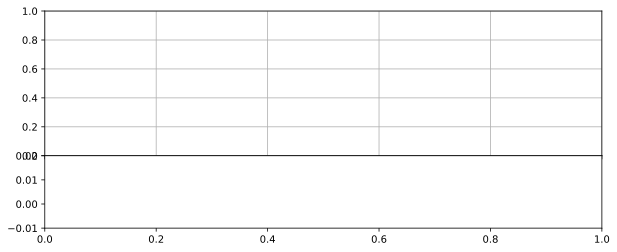

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10,4), gridspec_kw={'height_ratios':[2, 1]})

ax2.set_ylim(-0.01,0.02)
ax1.grid(True)
plt.subplots_adjust(hspace=.0)

plt.show()

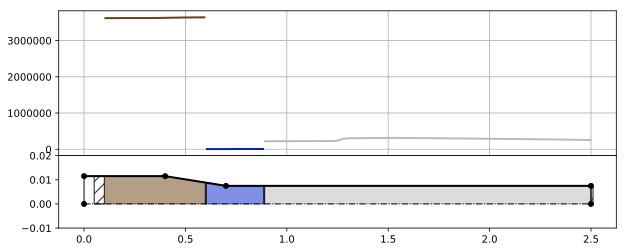

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10,4), gridspec_kw={'height_ratios':[2, 1]})
sandw.plot_param(fig, ax1, 'es')
sandw.plot(fig, ax2)
ax2.set_ylim(-0.01,0.02)
ax1.grid(True)
plt.subplots_adjust(hspace=.0)

plt.show()

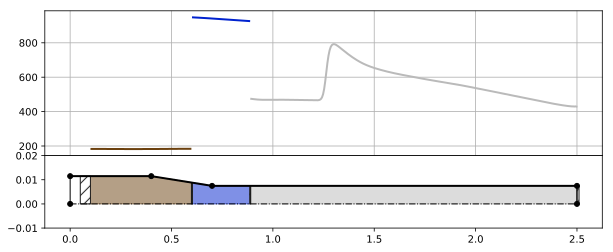

In [22]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10,4), gridspec_kw={'height_ratios':[2, 1]})
sandw.plot_param(fig, ax1, 'ros')
sandw.plot(fig, ax2)
ax2.set_ylim(-0.01,0.02)
ax1.grid(True)
plt.subplots_adjust(hspace=.0)

plt.show()

### Алибаев

Параметры следующие x1 = 0.328 m, x2 = 0.172 m, p1 = 4.578 MPa, p2 = 1.6 MPa. md = mp = 0.1 kg. pa = 0.
Общая длина 4.5 м (вместе с камерой).
воздух холодный

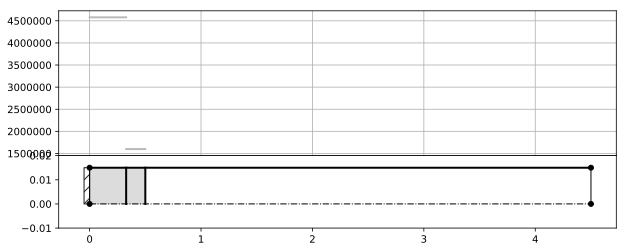

Sandwich i=0; t=0.0 ms;  vel=0.0 m/s;  p_max=4.577999999999999 MPa
layers:
0) GasLayer(n_cells=300); 
        {'p_max':4578000.0, 'tau_min': 2.9775200626527257e-06, 
        'u_max': 0.0, 'cs_max': 367.1959584914465, 'dx_min': 0.0010933333333332795, 
        'x_1': 0.0, 'x_2': 0.328,
        'V_1':  0.0, 'V_2':  0.0  }
1) GasLayer(n_cells=300); 
        {'p_max':1600000.0, 'tau_min': 1.6187571263405854e-06, 
        'u_max': 0.0, 'cs_max': 354.1811949451679, 'dx_min': 0.0005733333333333146, 
        'x_1': 0.328, 'x_2': 0.5,
        'V_1':  0.0, 'V_2':  0.0  }

In [39]:
sandwich_dict_sample = {
    'tube': {
        'tube_points': [[0, 0.03], [4.5, 0.03]]
    },
    'x_left': 0,
    'layers': [
        {
            'type': 'gas',
            'name': 'air',
            'gamma': 1.4,
            'kappa': 0.0010838,
            'R': 287,
            'T_0': 300, # K
#             'W_0': 0.0003,  # м^3 объем газа
            'p_0': 4.578e6, # начальное давление газа
            'u_0': 0,     #начальная скорость
            'x_2': 0.328
        },
        {
            'type': 'gas',
            'name': 'air',
            'gamma': 1.4,
            'kappa': 0.0010838,
            'R': 287,
            'T_0': 300, # K
#             'W_0': 0.0003,  # м^3 объем газа
            'p_0': 1.6e6, # начальное давление газа
            'u_0': 0,     #начальная скорость
            'x_2': 0.328 + 0.172
        }
        
    ],
    'borders': [
        {
            'mass': 1000, # kg
            'p_f': 100000e6, #Pa
            't_init': -1,
            'w_border': 0.05, #m
        },
        {
            'mass': 0.1, # kg
            'p_f': 0, #Pa
            't_init': -1,
            'w_border': 0, #m
        },
        {
            'mass': 0.1, # kg
            'p_f': 0, #Pa
            't_init': -1,
            'w_border': 0, #m
        },
    ],
    'calc_settings': {
        'gas_settings': {
            'cell_dx': 0.0005,
            'n_cells_min': 13,
            'n_cells_max': 300,
            'GasFluxCalculator_kwargs': {'flux_type':1},
            'GridStrecher_kwargs': {}
        },

    }
}

sandw = Sandwich.get_standart(sandwich_dict_sample)

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10,4), gridspec_kw={'height_ratios':[2, 1]})
sandw.plot_param(fig, ax1, 'ps')
sandw.plot(fig, ax2)
ax2.set_ylim(-0.01,0.02)
ax1.grid(True)
plt.subplots_adjust(hspace=.0)

plt.show()

sandw

In [40]:
sandw = Sandwich.get_standart(sandwich_dict_sample)
history = [sandw]
while sandw.get_x_projectile() <= sandw.tube.get_x_right():
# while sandw.layers[0].xs_borders[-1]<= sandw.tube.get_x_right():
    sandw = sandw.simple_step(0.35)
    history.append(sandw)
    if sandw.i > 30000:
        break
print(len(history))

25589


In [41]:
@interact(ind=ipywidgets.IntSlider(min=0,max=len(history)-1,step=100, value=len(history)-1))
def plotMe(ind):
    sandw = history[ind]

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(10,7), gridspec_kw={'height_ratios':[2, 2, 1]})
    sandw.plot_param(fig, ax1, 'ps')
    sandw.plot(fig, ax2)
    sandw.plot_param(fig, ax0, 'us')
    ax2.set_ylim(-0.01,0.04)
#     ax0.set_ylim(-1,1)
    ax1.grid(True)
    ax0.grid(True)
    plt.subplots_adjust(hspace=.0)

    plt.show()
    print(sandw)

interactive(children=(IntSlider(value=25588, description='ind', max=25588, step=100), Output()), _dom_classes=…

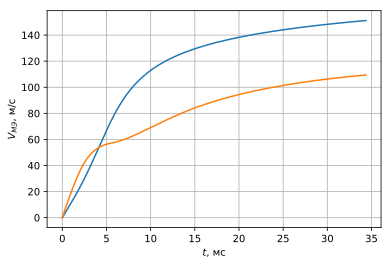

In [42]:
Vs = seq(history).map(lambda lr: lr.layers[-1].Vs_borders[-1]).to_list()
Vsd = seq(history).map(lambda lr: lr.layers[-1].Vs_borders[0]).to_list()
ts = seq(history).map(lambda lr: lr.layers[-1].time*1000).to_list()
plt.plot(ts, Vs)
plt.plot(ts, Vsd)
plt.xlabel('$t$, мс')
plt.ylabel('$V_{МЭ}$, м/с')
plt.grid()
plt.show()